In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)      # modify bounds to focus on region of interest

regions = ["EJB", "ES", "WJB"]     # homogenous fire regions to focus on

# **Questions**

- Do we want to look at intensity of FWI or or early-season FWI?

---
# **Preparatory**

## **Get x,y coordinates for ERA5 plotting**

In [3]:
# # Method to reproject lat/lon onto Lambert coordinates
# def latlon_to_lambert(da):
    
#     # convert dataArray to dataframe
#     df = da.to_dataframe().reset_index()
    
#     # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
#     gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
#     gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
#     x = np.reshape(np.array(gdf.geometry.x), da.shape)
#     y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
#     return x,y

In [10]:
# era5 = xr.open_dataset("data/percentile_99_map.nc").fwi

# convert lat & lon to Lambert x & y coords, ready to pass to plt.colormesh(x,y,da)
# x,y = latlon_to_lambert(era5)

# np.savetxt("data/lambert-x_era5.csv", x)
# np.savetxt("data/lambert-y_era5.csv", y)

## **Make shapefile of study region**

In [77]:
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")

# merge selected regions into a single polygon
sf_ejb = sf.loc[regions].dissolve().explode(index_parts = True)

# get single largest polygon (remove islands)
sf_ejb = sf_ejb.loc[[a == sf_ejb.geometry.area.max() for a in sf_ejb.geometry.area]]

# get external boundary (remove internal features)
sf_ejb["geometry"] = sf_ejb.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))  

sf_ejb.to_file("sf_ejb")

<AxesSubplot: >

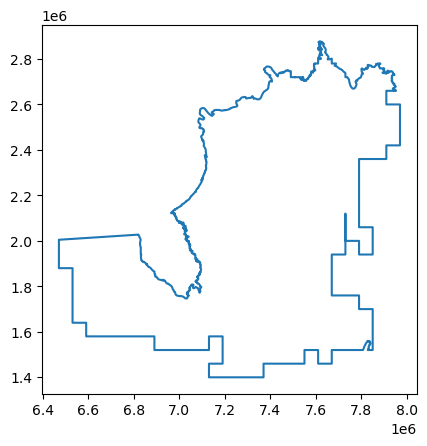

In [126]:
sf_ejb.boundary.plot()

## **Regionmasks for ERA5**

In [103]:
era5 = xr.open_dataset("data/percentile_99_map.nc").fwi.reset_coords(drop = True)

In [104]:
# whole of Canada
canada = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(era5.longitude, era5.latitude).sel(region = 3).reset_coords(drop = True)
canada = canada.where(canada == 1)
canada.to_netcdf("data/regionmask_era5_canada.nc")

In [105]:
# study region
ejb = gpd.read_file("sf_ejb").to_crs(cartopy.crs.PlateCarree())
ejb = regionmask.mask_3D_geopandas(ejb, era5.longitude, era5.latitude, numbers = "grid60km_n")
ejb = ejb.where(ejb == 1).squeeze(drop = True)
ejb.to_netcdf("data/regionmask_era5_ejb.nc")

## **Add regions to active fire data**

In [80]:
## MODIS

# load all fire data
df = pd.concat([pd.read_csv("data/fire_archive_M-C61_369626.csv"), pd.read_csv("data/fire_nrt_M-C61_369626.csv")])

# convert to geodataframe (standard lat-lon coords) & reproject geometry
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326")
df = df.to_crs(cproj)

# add year & month as columns for easier filtering
df["y"] = [int(d[:4]) for d in df.acq_date]
df["m"] = [int(d[5:7]) for d in df.acq_date]

# load shapefile of homogeneous fire regions
sf = gpd.read_file("sf_hfr").to_crs(cproj)

# assign each point to a fire region - takes ages so only doing this once! 
zz = gpd.overlay(df, sf, how='intersection')

# save as .csv (can restore geometry later) - also filter out partial year in 2000
zz.loc[zz.y > 2000].iloc[:,:-1].to_csv("data/modis-active-fires-with-hfr.csv", index = False)

---
# **Indices**

## **MODIS active fires**

Downloaded from https://firms.modaps.eosdis.nasa.gov/active_fire/

### **Fires per HFR**

In [151]:
df = pd.read_csv("data/modis-active-fires-with-hfr.csv", low_memory = False)
df = df.loc[df.acq_date < "2023-07"] # only include up to end of June

In [4]:
# aggregate annually by fire region
nfires = df[["y","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"])["NAMES_SHOR"].count().unstack()
nfires_mj = df.loc[[m in [5,6] for m in df.m], ["y","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"])["NAMES_SHOR"].count().unstack()
nfires_mjja = df.loc[[m in [5,6,7,8,9] for m in df.m], ["y","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"])["NAMES_SHOR"].count().unstack()

regions = ["EJB", "ES", "WJB"]

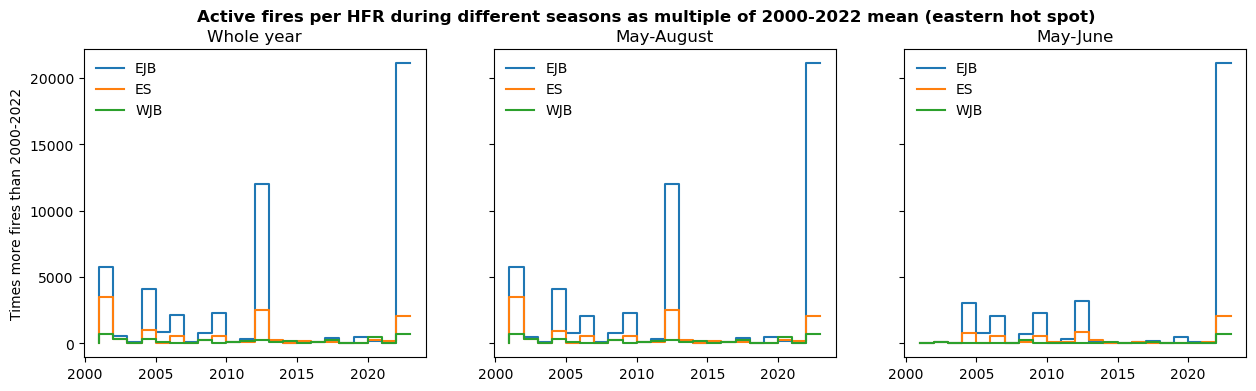

In [5]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharey = True, sharex = True)

nfires[regions].plot(ax = axs[0], drawstyle = "steps", ylabel = "Times more fires than 2000-2022", xlabel = "")
axs[0].set_title("Whole year")

nfires_mjja[regions].plot(ax = axs[1], drawstyle = "steps", xlabel = "")
axs[1].set_title("May-August")

nfires_mj[regions].plot(ax = axs[2], drawstyle = "steps", xlabel = "")
axs[2].set_title("May-June")

for ax in axs: ax.legend(edgecolor = "w", loc = "upper left")

plt.suptitle("Active fires per HFR during different seasons as multiple of 2000-2022 mean (eastern hot spot)", fontweight = "bold")
# not only is the May-June rate unusual but there are already 10-20 times more fires in May-June 2023 than we would expect in the whole year/fire season
# Definitely suggest focussing on this eastern region

plt.savefig("fig/event-def_active-fires-per-year.png")

In [6]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharey = True, sharex = True)

(nfires / nfires.loc[slice(None, "2022")].mean(axis = 0))[regions].plot(ax = axs[0], drawstyle = "steps", ylabel = "Times more fires than 2000-2022", xlabel = "")
axs[0].set_title("Whole year")

(nfires_mjja / nfires_mjja.loc[slice(None, "2022")].mean(axis = 0))[regions].plot(ax = axs[1], drawstyle = "steps", xlabel = "")
axs[1].set_title("May-August")

(nfires_mj / nfires_mj.loc[slice(None, "2022")].mean(axis = 0))[regions].plot(ax = axs[2], drawstyle = "steps", xlabel = "")
axs[2].set_title("May-June")

for ax in axs: ax.legend(edgecolor = "w", loc = "upper left")

plt.suptitle("Active fires per HFR during different seasons as multiple of 2000-2022 mean (eastern hot spot)", fontweight = "bold")
# not only is the May-June rate unusual but there are already 10-20 times more fires in May-June 2023 than we would expect in the whole year/fire season
# Definitely suggest focussing on this eastern region

plt.savefig("fig/event-def_active-fires-per-year-as-multiple.png")

In [10]:
(nfires_mj / nfires_mj.loc[slice(None, "2022")].mean(axis = 0))[regions].loc[2023]

NAMES_SHOR
EJB    34.819598
ES     12.343946
WJB    19.693316
Name: 2023, dtype: float64

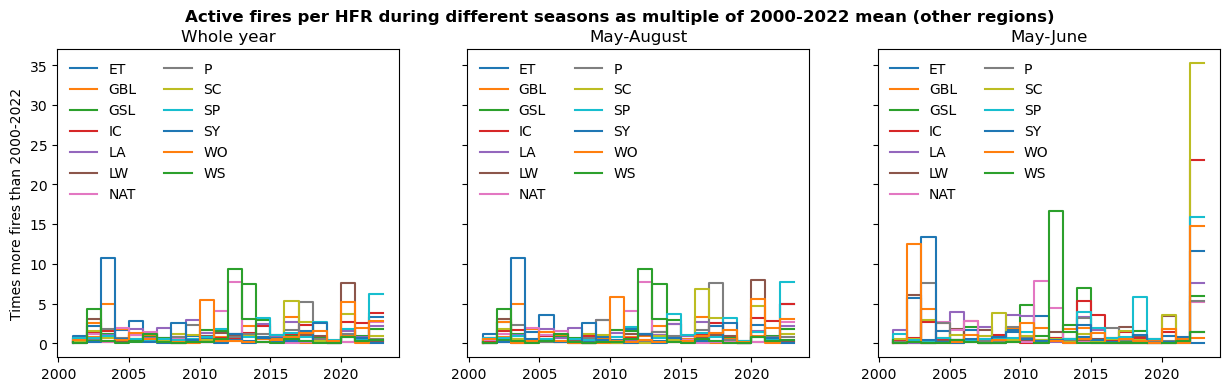

In [7]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharey = True, sharex = True)

(nfires / nfires.loc[slice(None, "2022")].mean(axis = 0))[[c for c in nfires.columns if not c in regions]].plot(ax = axs[0], drawstyle = "steps", ylabel = "Times more fires than 2000-2022", xlabel = "")
axs[0].set_title("Whole year")

(nfires_mjja / nfires_mjja.loc[slice(None, "2022")].mean(axis = 0))[[c for c in nfires.columns if not c in regions]].plot(ax = axs[1], drawstyle = "steps", xlabel = "")
axs[1].set_title("May-August")

(nfires_mj / nfires_mj.loc[slice(None, "2022")].mean(axis = 0))[[c for c in nfires.columns if not c in regions]].plot(ax = axs[2], drawstyle = "steps", xlabel = "")
axs[2].set_title("May-June")

for ax in axs: ax.legend(edgecolor = "w", loc = "upper left", ncols = 2)

plt.suptitle("Active fires per HFR during different seasons as multiple of 2000-2022 mean (other regions)", fontweight = "bold")

plt.savefig("fig/event-def_active-fires-per-year-elsewhere-as-multiple.png")

### **Maps of occurrences**

In [11]:
# load data, convert to geodataframe & reproject to correct geometry
df = pd.read_csv("data/modis-active-fires-with-hfr.csv", low_memory = False)
df = df.loc[df.acq_date < "2023-07"]         # only include up to end of June
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326")
df = df.to_crs(cproj)

# shapefile of fire regions
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
regions = ["EJB", "ES", "WJB"]

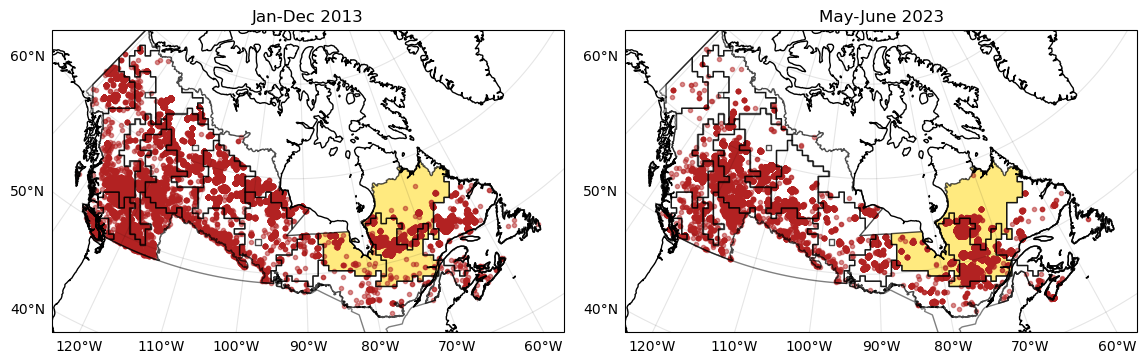

In [12]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (14,5), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.12)

for ax in fig.axes: sf.loc[regions].plot(ax = ax, color = "gold", alpha = 0.5)
    
df.loc[[y == 2013 for y in df.y]].plot(ax = axs[0], marker = ".", color = "firebrick", alpha = 0.5)
axs[0].set_title("Jan-Dec 2013")

df.loc[[y == 2023 for y in df.y]].plot(ax = axs[1], marker = ".", color = "firebrick", alpha = 0.5)
axs[1].set_title("May-June 2023")

for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.7)
    
plt.savefig("fig/event-def_active-fire-map.png")

## **fwi7x**

In [3]:
# # Monthly maximum of 7-day rolling mean of FWI (processed per decade to avoid handling 7gb of data at once)
# fwi7x = []
# for y in range(1940,2030,10):
    
#     # load daily FWI, replace all missing values with 0 (needed for correct averaging over region)
#     fwi = xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi.load()
#     fwi = fwi.where(~np.isnan(fwi), 0)
    
#     # monthly maximum of 7-day rolling mean of FWI
#     fwi7 = fwi.rolling(time = 7).mean().resample(time = "MS").max()
    
#     # add to list
#     fwi7x.append(fwi7)

# # concatenate the decades into a single dataArray & rename
# fwi7x = xr.concat(fwi7x, "time").rename("fwi7x")

# # ensure that all values are nonnegative (sometimes occurs due to numerical instabilities)
# fwi7x = fwi7x.where(fwi7x >= 0, 0)

# # apply Canada regionmask
# rm_canada = xr.open_dataset("data/regionmask_era5_canada.nc").mask
# fwi7x = fwi7x.where(rm_canada == 1)

# # and save
# fwi7x.to_netcdf("data/era5_fwi7x-monthly.nc")

In [10]:
fwi7x = xr.open_dataset("data/era5_fwi7x-monthly.nc").fwi7x

x,y = [np.loadtxt("data/lambert-"+d+"_era5.csv") for d in ["x", "y"]]    # load Lambert projected coordinates
fwi7x = fwi7x.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y))
# fwi7x = fwi7x.where(~np.isnan(fwi7x), 0)    # replace missing values with 0 - otherwise averaging comes out with odd results

# load shapefiles for plotting
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

# load regionmasks
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

fwi7x_ejb = fwi7x.where(rm_ejb == 1)

### **Timing of annual maxima**

Text(0, 0.5, 'Month')

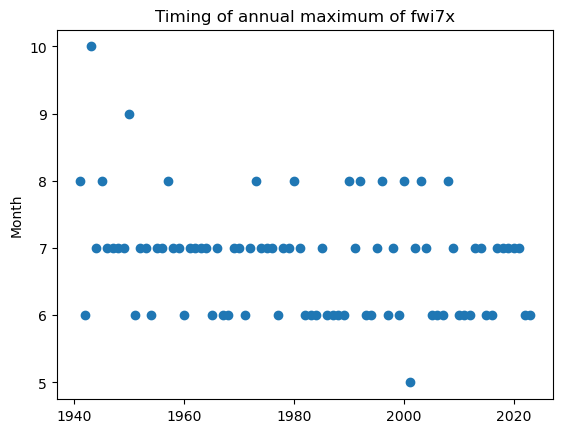

In [89]:
fwi7x_m = fwi7x.where(rm_ejb).mean(["latitude", "longitude"])
m_max = xr.concat([fwi7x_m.sel(time = str(y)).idxmax().dt.month.expand_dims(year = [y]) for y in range(1941,2024)], "year")
plt.scatter(m_max.year, m_max)
plt.title("Timing of annual maximum of fwi7x")
plt.ylabel("Month")

### **Monthly fwi7x**

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


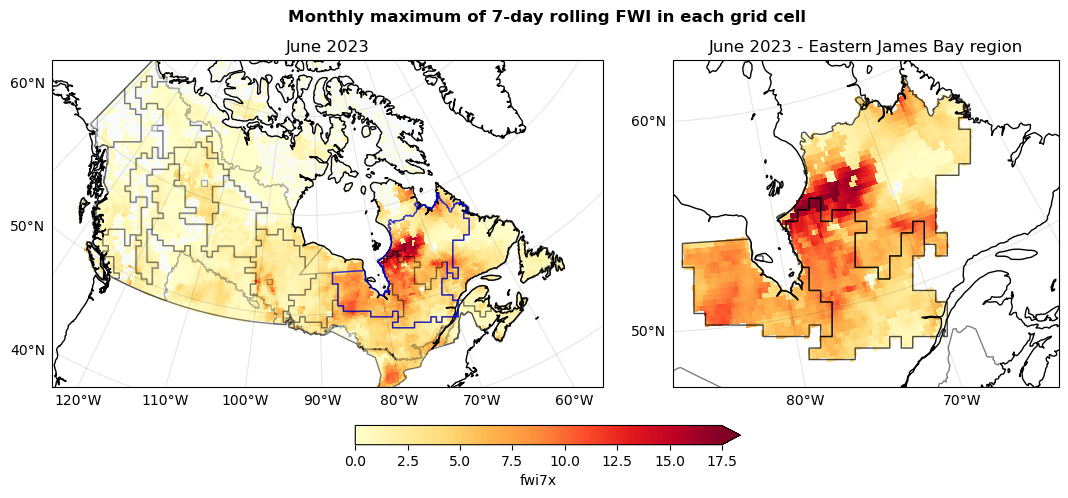

In [28]:
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0, "vmax" : 17.5}

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (13.5,5), dpi = 100, subplot_kw = {"projection" : cproj}, gridspec_kw = {"width_ratios" : [1.3,1]})
plt.subplots_adjust(wspace = 0.06)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(x,y,fwi7x.sel(time = "2023-06-01"), **plot_kwargs)
axs[0].pcolormesh(x,y,fwi7x.where(fwi7x == 0).sel(time = "2023-06-01"), cmap = "Blues")
axs[0].set_title("June 2023")
sf.boundary.plot(ax = axs[0], color = "k", lw = 1, alpha = 0.3)
sf_ejb.boundary.plot(ax = axs[0], color = "blue", lw = 1, alpha = 0.7)

axs[1].pcolormesh(fwi7x_ejb.x,fwi7x_ejb.y,fwi7x_ejb.sel(time = "2023-06-01"), **plot_kwargs)
axs[1].pcolormesh(fwi7x_ejb.x,fwi7x_ejb.y,fwi7x_ejb.where(fwi7x_ejb == 0).sel(time = "2023-06-01"), cmap = "Blues")

sf.loc[regions].boundary.plot(ax = axs[1], color = "k", lw = 1, alpha = 0.7)
axs[1].set_title("June 2023 - Eastern James Bay region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "fwi7x", extend = "max")

plt.suptitle("Monthly maximum of 7-day rolling FWI in each grid cell", fontweight = "bold")

plt.savefig("fig/event-def_fwi7x-2023.png")

### **Annual fwi7x**

In [30]:
fwi7x_ymax = fwi7x.resample(time = "AS-JAN").max()

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. Th

Text(0.5, 0.98, 'Annual maximum of 7-day rolling FWI in each grid cell')

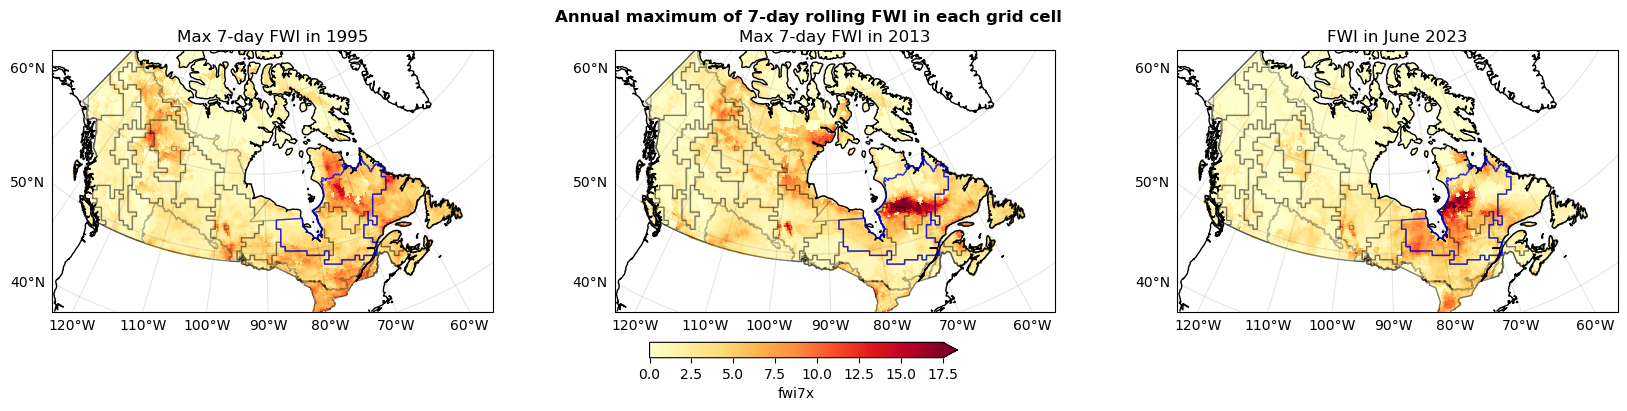

In [37]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (21,4), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.12)
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0, "vmax" : 17.5}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(x,y,fwi7x_ymax.where(rm_canada ==1).sel(time = "1995-01-01"), **plot_kwargs)
axs[0].set_title("Max 7-day FWI in 1995")

cbar = axs[1].pcolormesh(x,y,fwi7x_ymax.where(rm_canada ==1).sel(time = "2013-01-01"), **plot_kwargs)
axs[1].set_title("Max 7-day FWI in 2013")

axs[2].pcolormesh(x,y,fwi7x_ymax.where(rm_canada ==1).sel(time = "2023-01-01"), **plot_kwargs)
axs[2].set_title("FWI in June 2023")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.3)
    sf_ejb.boundary.plot(ax = ax, color = "blue", lw = 1, alpha = 0.7)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "fwi7x", extend = "max")

plt.suptitle("Annual maximum of 7-day rolling FWI in each grid cell", fontweight = "bold")

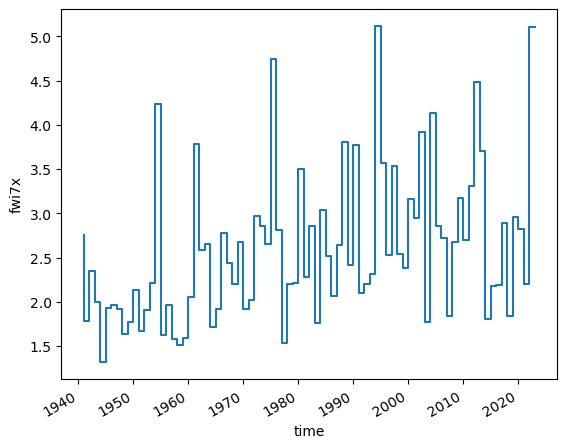

In [34]:
fwi7x_ts = fwi7x_ymax.where(rm_ejb).mean(["latitude", "longitude"])
fwi7x_ts.plot(drawstyle = "steps")



#### **Correlation with number of active fires**


In [38]:
# load active fire data
df = pd.read_csv("data/modis-active-fires-with-hfr.csv", low_memory = False)
df = df.loc[df.acq_date < "2023-07"] # only include up to end of June

# aggregate annually by fire region
nfires = df[["y","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"])["NAMES_SHOR"].count().unstack()[regions].sum(axis = 1)

In [42]:
# where available, approximate linear relationship with log of number of fires (Pearson correlation coeff 0.79) - especially for very high/very low values
plt.scatter(fwi7x_ts.sel(time = slice("2001",None)), np.log(nfires))
xyline(fwi7x_ts.sel(time = slice("2001",None)), np.log(nfires), ax = plt.gca())
np.corrcoef(fwi7x_ts.sel(time = slice("2001",None)), np.log(nfires))[0,1]

#### **Time series for climate explorer**


In [300]:
fwi7x = xr.open_dataset("data/era5_fwi7x-monthly.nc").fwi7x

fwi7x_mjmax = fwi7x.sel(time = [m in [5,6] for m in fwi7x.time.dt.month]).resample(time = "AS-JAN").max().where(rm_ejb).mean(["latitude", "longitude"])
fwi7x_mjjamax = fwi7x.sel(time = [m in [5,6,7,8] for m in fwi7x.time.dt.month]).resample(time = "AS-JAN").max().where(rm_ejb).mean(["latitude", "longitude"])

In [301]:
# fix filename
csv_fnm = "ts/canada-wildfires_era5_fwi7x-mj.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 fwi7x - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi7x [] spatial mean of May-June maximum of 7-day average of FWI over wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi7x"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi7x_mjmax.assign_coords(time = fwi7x_mjmax.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [302]:
# fix filename
csv_fnm = "ts/canada-wildfires_era5_fwi7x-mjja.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 fwi7x - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi7x [] spatial mean of May-August maximum of 7-day average of FWI over wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi7x"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi7x_mjjamax.assign_coords(time = fwi7x_mjjamax.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

## **fwi99**

### **Time series for climate explorer**


In [265]:
# 99th percentile of FWI in across all cells in study region (processed per decade to avoid handling 7gb of data at once)
fwi_99_mj = []
fwi_99_mjja = []

# load regionmask to select area of interest
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

# loop over decadal files & compute indices
for y in range(1940,2030,10):
    
    # load daily FWI, replace all missing values with 0 (needed for correct averaging over region)
    fwi = xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi.load()
    fwi = fwi.where(~np.isnan(fwi), 0).where(rm_ejb == 1)
    
    # find 99th percentile of FWI per year & add to list
    fwi_99_mj.append(fwi.sel(time = [m in [5,6] for m in fwi.time.dt.month]).resample(time = "AS-JAN").quantile(0.99, ["latitude", "longitude", "time"]))
    fwi_99_mjja.append(fwi.sel(time = [m in [5,6,7,8] for m in fwi.time.dt.month]).resample(time = "AS-JAN").quantile(0.99, ["latitude", "longitude", "time"]))
    
# concatenate the decades into a single dataArray & rename
fwi_99_mj = xr.concat(fwi_99_mj, "time").reset_coords(drop = True)
fwi_99_mjja = xr.concat(fwi_99_mjja, "time").reset_coords(drop = True)

In [288]:
fwi_99_mj.to_netcdf("data/era5_fwi99-mj.csv")
fwi_99_mjja.to_netcdf("data/era5_fwi99-mjja.csv")

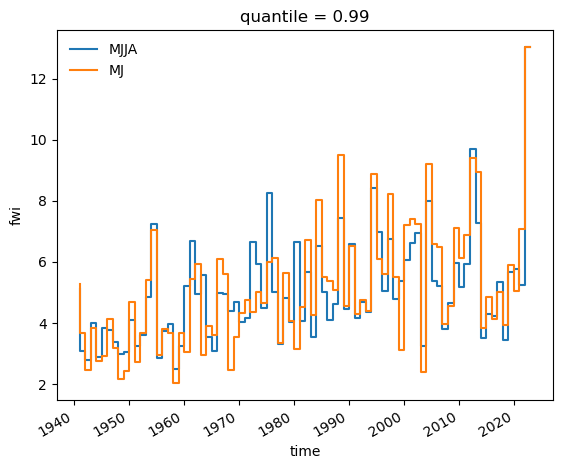

In [243]:
fwi_99_mjja.plot(drawstyle = "steps", label = "MJJA")
fwi_99_mj.plot(drawstyle = "steps", label = "MJ")
plt.legend(edgecolor = "w")

plt.savefig("fig/event-def_fwi99-ts.png")

In [272]:
# fix filename
csv_fnm = "ts/canada-wildfires_era5_fwi99-mj.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 fwi99_mj - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi99_mj [] 99th percentile of May-June FWI over all days & grid cells in wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi99_mj"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi_99_mj.assign_coords(time = fwi_99_mj.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [273]:
# fix filename
csv_fnm = "ts/canada-wildfires_era5_fwi99-mjja.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 fwi99_mjja - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi99_mjja [] 99th percentile of May-August FWI over all days & grid cells in wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi99_mjja"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi_99_mjja.assign_coords(time = fwi_99_mjja.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Distribution of FWI annually**


In [111]:
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

In [138]:
fwi_2005 = xr.open_dataset("data/era5/fwi_era5_2000-2009.nc").fwi.load().sel(time = slice("2005-05", "2005-08")).where(rm_ejb == 1)
fwi_2013 = xr.open_dataset("data/era5/fwi_era5_2010-2019.nc").fwi.load().sel(time = slice("2013-05", "2013-08")).where(rm_ejb == 1)
fwi_2023 = xr.open_dataset("data/era5/fwi_era5_2020-2029.nc").fwi.load().sel(time = slice("2023-05", "2023-08")).where(rm_ejb == 1)

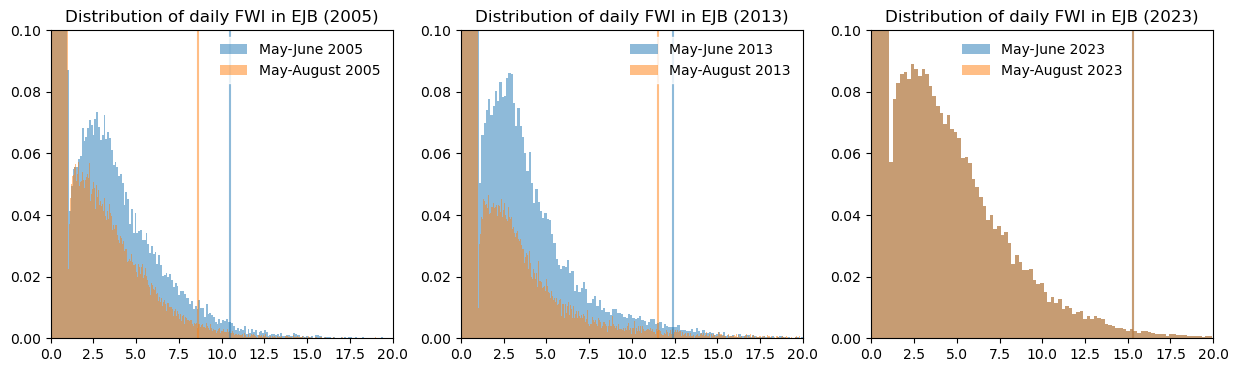

In [141]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100)

for i in range(3):
    y = ["2005", "2013", "2023"][i]
    ax = axs[i]
    
    fwi_da = eval("fwi_"+y)
    
    ax.hist((fwi_da.sel(time = slice(y+"-05", y+"-06")).stack(txy = ["time", "latitude", "longitude"])), bins = "fd", density = True, alpha = 0.5, label = "May-June "+y)
    ax.hist((fwi_da.stack(txy = ["time", "latitude", "longitude"])), bins = "fd", density = True, alpha = 0.5, label = "May-August "+y)
    ax.legend(edgecolor = "w")
    
    ax.axvline(fwi_da.sel(time = slice(y+"-05", y+"-06")).quantile(0.99), alpha = 0.5)
    ax.axvline(fwi_da.sel(time = slice(y+"-05", y+"-08")).quantile(0.99), alpha = 0.5, color = "tab:orange")
   
    ax.set_ylim(0,.1)
    ax.set_xlim(0,20)
    ax.set_title("Distribution of daily FWI in EJB ("+y+")")

## **Monthly severity rating**

In [190]:
# # Monthly mean of daily severity rating
# msr = []
# for y in range(1940,2030,10):
    
#     fwi = xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi.load()
#     fwi = fwi.where(~np.isnan(fwi), 0)
#     dsr = (fwi ** 1.71) * 0.0272
#     msr.append(dsr.resample(time = "MS").mean().rename("msr"))
    
# msr = xr.concat(msr, "time")

# # apply Canada regionmask
# rm_canada = xr.open_dataset("data/regionmask_era5_canada.nc").mask
# msr = msr.where(rm_canada == 1)

# msr.to_netcdf("data/era5_msr-monthly.nc")

### **Relationship between FWI and DSR**

In [220]:
fwi = xr.open_dataset("data/era5/fwi_era5_2020-2029.nc").fwi
fwi = fwi.where(~np.isnan(fwi), 0)
dsr = (fwi ** 1.71) * 0.0272

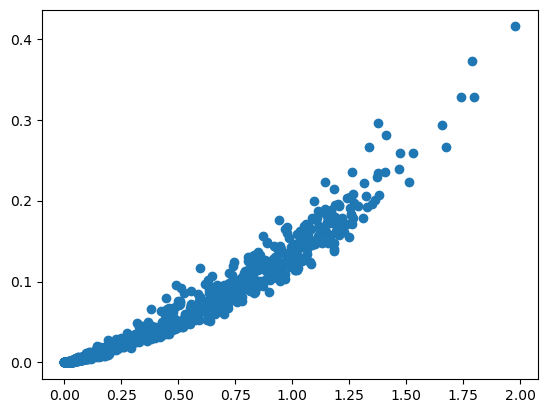

In [231]:
plt.scatter(fwi.mean(["latitude", "longitude"]), dsr.mean(["latitude", "longitude"]))
# so: higher values of 

### **Monthly MSR**

In [202]:
msr = xr.open_dataset("data/era5_msr-monthly.nc").msr

x,y = [np.loadtxt("data/lambert-"+d+"_era5.csv") for d in ["x", "y"]]    # load Lambert projected coordinates
msr = msr.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y))

# load shapefiles for plotting
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

# load regionmasks
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

msr_ejb = msr.where(rm_ejb == 1)

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


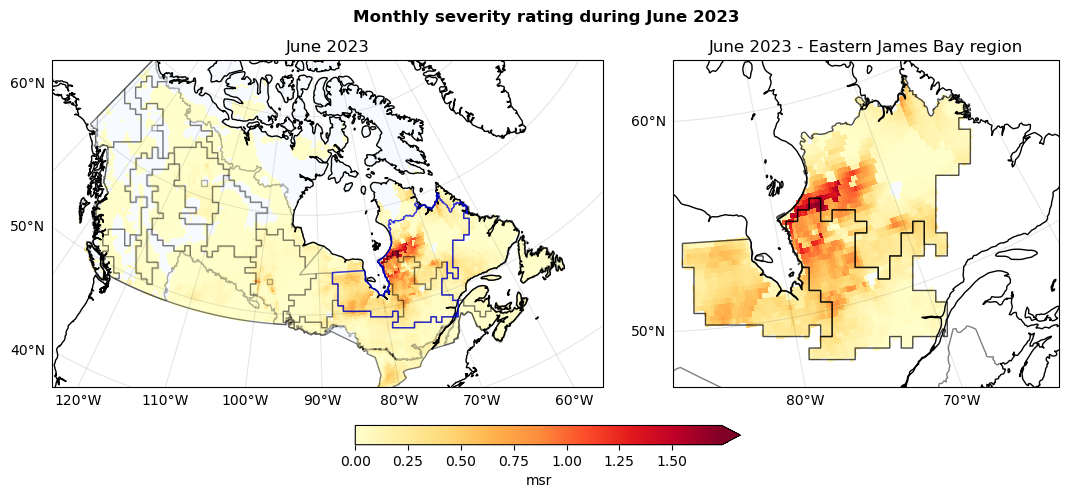

In [242]:
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0}

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (13.5,5), dpi = 100, subplot_kw = {"projection" : cproj}, gridspec_kw = {"width_ratios" : [1.3,1]})
plt.subplots_adjust(wspace = 0.06)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(x,y,msr.sel(time = "2023-06-01"), **plot_kwargs)
axs[0].pcolormesh(x,y,msr.where(msr == 0).sel(time = "2023-06-01"), cmap = "Blues")
axs[0].set_title("June 2023")
sf.boundary.plot(ax = axs[0], color = "k", lw = 1, alpha = 0.3)
sf_ejb.boundary.plot(ax = axs[0], color = "blue", lw = 1, alpha = 0.7)

axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb.sel(time = "2023-06-01"), **plot_kwargs)
axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb.where(msr_ejb == 0).sel(time = "2023-06-01"), cmap = "Blues")

sf.loc[regions].boundary.plot(ax = axs[1], color = "k", lw = 1, alpha = 0.7)
axs[1].set_title("June 2023 - Eastern James Bay region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "msr", extend = "max")

plt.suptitle("Monthly severity rating during June 2023", fontweight = "bold")

plt.savefig("fig/event-def_msr-2023.png")
# maps aren't going to add much beyond the fwi7x ones - include as supplement only

### **Time series of max vs mean**

In [295]:
msr_mj_mean = msr.sel(time = [m in [5,6] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").mean()
msr_mjja_mean = msr.sel(time = [m in [5,6,7,8] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").mean()

msr_mj_max = msr.sel(time = [m in [5,6] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").max()
msr_mjja_max = msr.sel(time = [m in [5,6,7,8] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").max()

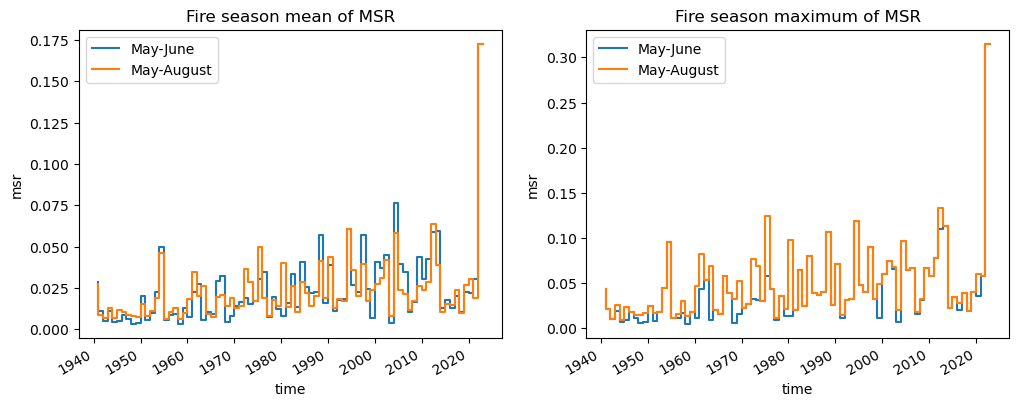

In [297]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

msr_mj_mean.plot(ax = axs[0], drawstyle = "steps", label = "May-June")
msr_mjja_mean.plot(ax = axs[0], drawstyle = "steps", label = "May-August")
axs[0].set_title("Fire season mean of MSR")
axs[0].legend()

msr_mj_max.plot(ax = axs[1], drawstyle = "steps", label = "May-June")
msr_mjja_max.plot(ax = axs[1], drawstyle = "steps", label = "May-August")
axs[1].set_title("Fire season maximum of MSR")
axs[1].legend()

## **Time series of candidate indices**

In [291]:
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fwi99
fwi99_mj = xr.open_dataset("data/era5_fwi99-mj.csv").fwi
fwi99_mjja = xr.open_dataset("data/era5_fwi99-mjja.csv").fwi

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fwi7x
fwi7x = xr.open_dataset("data/era5_fwi7x-monthly.nc").fwi7x

fwi7x_mjmax = fwi7x.sel(time = [m in [5,6] for m in fwi7x.time.dt.month]).resample(time = "AS-JAN").max().where(rm_ejb).mean(["latitude", "longitude"])
fwi7x_mjjamax = fwi7x.sel(time = [m in [5,6,7,8] for m in fwi7x.time.dt.month]).resample(time = "AS-JAN").max().where(rm_ejb).mean(["latitude", "longitude"])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# MSR
msr = xr.open_dataset("data/era5_msr-monthly.nc").msr

msr_mjmean = msr.sel(time = [m in [5,6] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").mean()
msr_mjjamean = msr.sel(time = [m in [5,6,7,8] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").mean()

msr_mjmax = msr.sel(time = [m in [5,6] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").max()
msr_mjjamax = msr.sel(time = [m in [5,6,7,8] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").max()

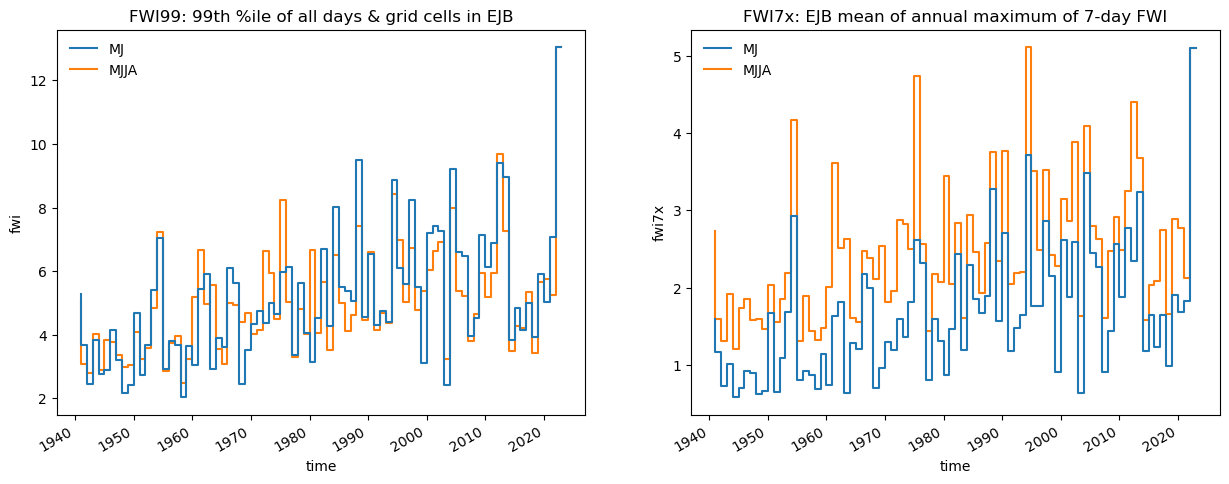

In [299]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,5), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fwi99_mj.plot(ax = axs[0], drawstyle = "steps", label = "MJ", zorder = 9)
fwi99_mjja.plot(ax = axs[0], drawstyle = "steps", label = "MJJA")
axs[0].legend(["MJ", "MJJA"], edgecolor = "w")
axs[0].set_title("FWI99: 99th %ile of all days & grid cells in EJB")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fwi7x_mjmax.plot(ax = axs[1], drawstyle = "steps", label = "MJ", zorder = 9)
fwi7x_mjjamax.plot(ax = axs[1], drawstyle = "steps", label = "MJJA")
axs[1].legend(["MJ", "MJJA"], edgecolor = "w")
axs[1].set_title("FWI7x: EJB mean of annual maximum of 7-day FWI")

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# msr_mjmax.plot(ax = axs[2], drawstyle = "steps", label = "MJ")
# msr_mjjamax.plot(ax = axs[2], drawstyle = "steps", label = "MJJA")
# axs[2].set_title("MSR: Annual max of EJB mean of monthly severity")
# axs[2].legend(edgecolor = "w")

plt.savefig("fig/event-def_candidate-timeseries.png")